In [263]:
"""
auteur:Alexandre
date:2024/09/05

Utilsation d'un algorithme de machine learning supervisé pour trouvé des paramètres permettant de prédire le résultats des élections
On cherche donc à prédire le partis gagnant en fonction de divers paramètres des bureax de votes
"""

"\nauteur:Alexandre\ndate:2024/09/05\n\nUtilsation d'un algorithme de machine learning supervisé pour trouvé des paramètres permettant de prédire le résultats des élections\nOn cherche donc à prédire le partis gagnant en fonction de divers paramètres des bureax de votes\n"

# **Analyse supervisée des bureaux de votes**

In [264]:
from sklearn.preprocessing import LabelEncoder, RobustScaler, Normalizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

## Importation des données

In [265]:
import preprocessing as pp
import params as prm

In [266]:
data_2 = pp.load_data(file_name=f"{prm.dataset_2nd_tour}.csv")
df, Gagnant = pp.prepare_supervised(df=data_2)

## Model de classification

In [267]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [268]:
class Decodeur(torch.nn.Module):
    def __init__(self, N_1, N_2):
        super(Decodeur, self).__init__()

        self.linear = torch.nn.Linear(in_features=N_1, out_features=N_2)
        self.logsoftmax = torch.nn.LogSoftmax(dim=-1)

    def forward(self, x):
        
        x_in = self.linear(x)
        output = self.logsoftmax(x_in)
        
        return output

In [269]:
def fit_data(
    X,
    Y,
    
    lr=1e-6,
    batch_size=64,
    num_epochs=500,
    
    seed=2022,
    device="cuda"
):
    # Paramètrage des calculs
    if device == "cpu":
        print(f"Il semble y avoir {os.cpu_count()} coeurs dans cet ordi !")
    elif device == "cuda":
        if torch.cuda.is_available() == True:
            print("GPU ! GPU ! GPU !")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device == "cuda": torch.cuda.empty_cache()

    # Preparation des données
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=.2, 
        random_state=seed, 
        shuffle=True,
    )

    loader = DataLoader(
                    TensorDataset(
                        torch.Tensor(X_train).to(device), 
                        torch.Tensor(Y_train).to(device)
                    ), batch_size=batch_size, shuffle=True
                )
    
    # Préparation du modèle
    N_1, N_2 = X.shape[-1], np.unique(Y).shape[0]
    decodeur = Decodeur(
        N_1=N_1,
        N_2=N_2
    )
    decodeur = decodeur.to(device)

    # Préparation de l'apprentissage
    optimizer = torch.optim.Adam(
        decodeur.parameters(), 
        lr=lr
    )
    criterion = torch.nn.NLLLoss(reduction="mean")

    losses_train = []
    losses_test = []

    for epoch in tqdm(range(int(num_epochs)), desc=f"Computing on {device}"):
        
        for x, y in loader:

            x, y = x.to(device), y.to(device)
            
            y_pred = decodeur(x)
            
            loss_train = criterion(y_pred, y.long())
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        losses_train.append(loss_train.cpu().detach().item())

        with torch.no_grad():
            
            x_test = torch.Tensor(X_test).to(device)
            y_test = torch.Tensor(Y_test).to(device)

            y_pred = decodeur(x_test)

            losse_test = criterion(y_pred, y_test.long())

            losses_test.append(losse_test.cpu().detach().item())

    return decodeur, np.array(losses_train), np.array(losses_test), y_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy()

## Départements

In [270]:
X = df["Code département"]
Y = Gagnant

In [271]:
OHE_departements = OneHotEncoder(sparse_output=False).fit(X.to_numpy()[:,None])
X_r = OHE_departements.transform(X.to_numpy()[:,None])
Encoder_departements = LabelEncoder().fit(Y.to_numpy())
Y_r = Encoder_departements.transform(Y.to_numpy())

In [272]:
num_epoch = 500
batch_size = 2**5
lr = 1e-5

In [273]:
decodeur, losses_train, losses_test, y_test, y_pred = fit_data(
    X=X_r,
    Y=Y_r,
    device="cpu",
    num_epochs=num_epoch,
    batch_size=batch_size,
    lr=lr
)
Weights = torch.softmax(decodeur.linear.weight.cpu(), axis=1).detach().numpy()

Il semble y avoir 16 coeurs dans cet ordi !


Computing on cpu: 100%|██████████| 500/500 [09:06<00:00,  1.09s/it]


In [274]:
# Path pour l'enregistrement des données
results_path = os.path.join(prm.cwd, "results")
result_path = os.path.join(results_path,f"C1_departement_{len(os.listdir(results_path))}")

# Enregistrement des données
if not(os.path.exists(result_path)):
    os.mkdir(result_path)
np.save(os.path.join(result_path, "loss_train"), losses_train)
np.save(os.path.join(result_path, "loss_test"), losses_test)
np.save(os.path.join(result_path, "pred"), y_pred)
np.save(os.path.join(result_path, "test"), y_test)

# Enregistrement des paramètres de l'entrainement
fichier = open(os.path.join(result_path, "info.txt"), "w")
fichier.write(f"{num_epoch = }\n")
fichier.write(f"{batch_size = }\n")
fichier.write(f"{lr = }")
fichier.close()

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of labels (106).

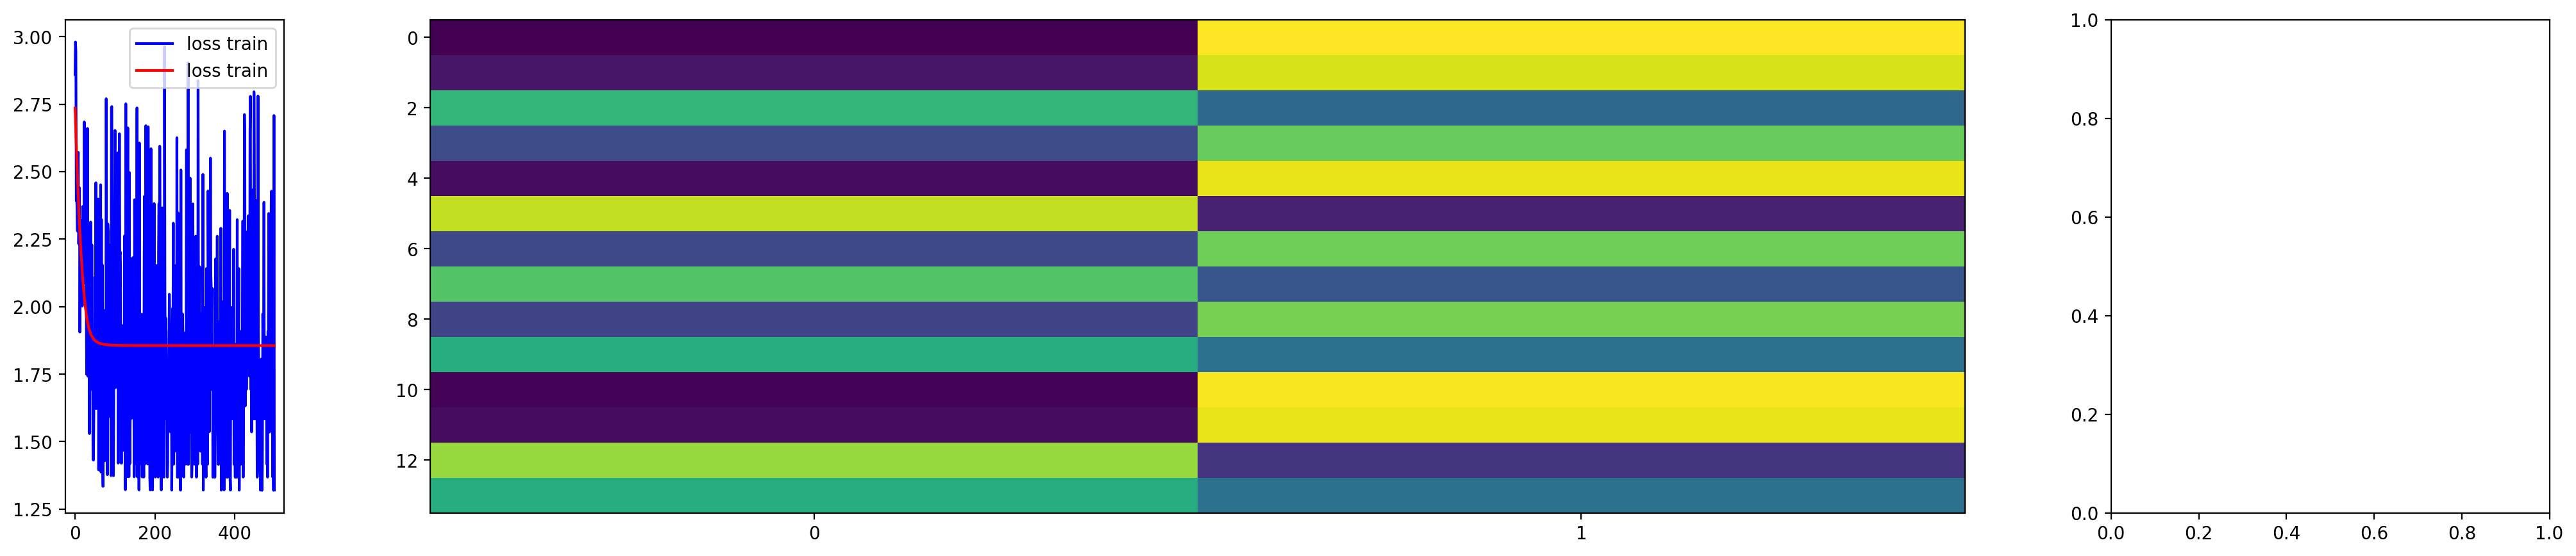

In [335]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(25,5),
    gridspec_kw={"width_ratios":[0.1,0.7,0.2]},
    dpi=200
)

ax[0].plot(
    range(num_epoch),
    losses_train,
    label="loss train",
    color="blue"
)
ax[0].plot(
    range(num_epoch),
    losses_test,
    label="loss train",
    color="red"
)
ax[0].legend()

g = ax[1].imshow(
    Weights,
    aspect="auto", 
    cmap="viridis"
)

ax[1].set_xticks(
    range(Weights.shape[-1]),
    OHE_departements.categories_[0],
    rotation=90
)

ax[1].set_yticks(
    range(Weights.shape[0]),
    Encoder_departements.classes_,
    rotation=45
)

ax[2].imshow(
    confusion_matrix(y_test, np.argmax(y_pred, axis=1)),
    origin="lower",
    aspect="auto"
)
ax[2].set_xticks(
    range(Encoder_departements.classes_.shape[0]),
    Encoder_departements.classes_,
    rotation=45
)
ax[2].set_yticks(
    range(Encoder_departements.classes_.shape[0]),
    Encoder_departements.classes_,
    rotation=45
)

ax[0].set_title("Courbes d'apprentissage")
ax[1].set_title("Poids des paramètres")
ax[2].set_title("Matrice de confusion")
plt.tight_layout()
plt.show()

In [287]:
print(f"balanced accuracy = {balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(y_pred, axis=-1)) * 100:.3f} %")
print(f"balanced accuracy (shuffle) = {balanced_accuracy_score(y_true=y_test, y_pred=shuffle(np.argmax(y_pred, axis=-1))) * 100:.3f} %")

balanced accuracy = 22.322 %
balanced accuracy (shuffle) = 7.276 %


## Participations

In [298]:
X = df[df.keys()[3:]]
Y = Gagnant
Encoder_departements = LabelEncoder().fit(Y.to_numpy())
Y_r = Encoder_departements.transform(Y.to_numpy())
# Normaliseur = Normalizer().fit(X.T)
# X_r = Normaliseur.transform(X.T).T
Robustscaler = RobustScaler().fit(X) # Scaling des différentes features
X_r = Robustscaler.transform(X)

In [303]:
num_epoch = 200
batch_size = 2**5
lr = 1e-5

In [304]:
decodeur, losses_train, losses_test, y_test, y_pred = fit_data(
    X=X_r,
    Y=Y_r,
    device="cpu",
    num_epochs=num_epoch,
    batch_size=batch_size,
    lr=lr
)
Weights = torch.softmax(decodeur.linear.weight.cpu(), axis=1).detach().numpy()

Il semble y avoir 16 coeurs dans cet ordi !


Computing on cpu: 100%|██████████| 200/200 [03:35<00:00,  1.08s/it]


In [44]:
# Path pour l'enregistrement des données
results_path = os.path.join(prm.cwd, "results")
result_path = os.path.join(results_path,f"C1_participation_{len(os.listdir(results_path))}")

# Enregistrement des données
if not(os.path.exists(result_path)):
    os.mkdir(result_path)
np.save(os.path.join(result_path, "loss_train"), losses_train)
np.save(os.path.join(result_path, "loss_test"), losses_test)
np.save(os.path.join(result_path, "pred"), y_pred)
np.save(os.path.join(result_path, "test"), y_test)

# Enregistrement des paramètres de l'entrainement
fichier = open(os.path.join(result_path, "info.txt"), "w")
fichier.write(f"{num_epoch = }\n")
fichier.write(f"{batch_size = }\n")
fichier.write(f"{lr = }")
fichier.close()

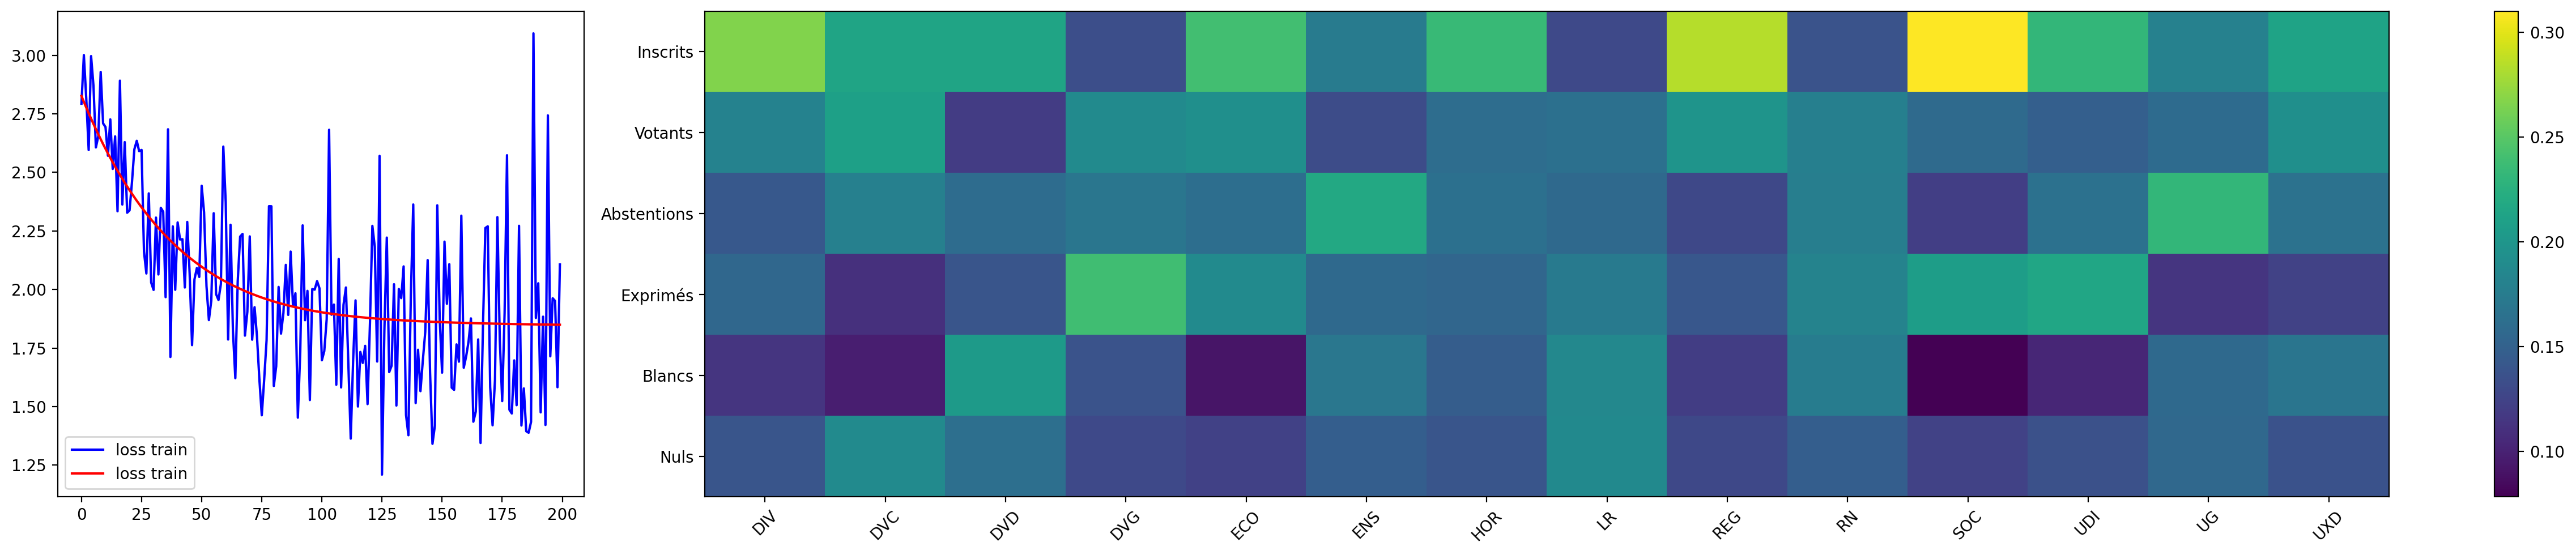

In [306]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(25,5),
    gridspec_kw={"width_ratios":[0.2,0.8]},
    dpi=200
)

ax[0].plot(
    range(num_epoch),
    losses_train,
    label="loss train",
    color="blue"
)
ax[0].plot(
    range(num_epoch),
    losses_test,
    label="loss train",
    color="red"
)
ax[0].legend()

g = ax[1].imshow(
    Weights.T,
    aspect="auto", cmap="viridis"
)
fig.colorbar(
    g,
    ax=ax[1]
)

ax[1].set_yticks(
    range(Weights.shape[-1]),
    df.keys()[3:]
)

ax[1].set_xticks(
    range(Weights.shape[0]),
    Encoder_departements.classes_,
    rotation=45
)

plt.tight_layout()
plt.show()

In [307]:
print(f"balanced accuracy = {balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(y_pred, axis=-1)) * 100:.3f} %")
print(f"balanced accuracy (shuffle) = {balanced_accuracy_score(y_true=y_test, y_pred=shuffle(np.argmax(y_pred, axis=-1))) * 100:.3f} %")

balanced accuracy = 7.207 %
balanced accuracy (shuffle) = 7.068 %


## Réussite au brevet

In [334]:
resultats_dnb = pd.read_csv(
    os.path.join(prm.datasets_pp_path, "fr-en-dnb-par-etablissement.csv"),
    low_memory=False
)

In [310]:
each_dprtmnt = []

for dprtmnt in resultats_dnb["code_departement"].unique():
        
      if dprtmnt == "02A" or dprtmnt == "02B":
            each_dprtmnt.append(
                  [
                        dprtmnt[1:],
                        resultats_dnb["admis"][resultats_dnb["code_departement"] == dprtmnt].sum(),
                        resultats_dnb["admis_mention_tres_bien"][resultats_dnb["code_departement"] == dprtmnt].sum()
                  ]
                    )
      
      else:
            if int(dprtmnt) > 9:
                  
                  each_dprtmnt.append(
                        [
                              str(int(dprtmnt)),
                              resultats_dnb["admis"][resultats_dnb["code_departement"] == dprtmnt].sum(),
                              resultats_dnb["admis_mention_tres_bien"][resultats_dnb["code_departement"] == dprtmnt].sum()
                        ]
                        )
            
            else:
                  each_dprtmnt.append(
                        [
                              dprtmnt[1:],
                              resultats_dnb["admis"][resultats_dnb["code_departement"] == dprtmnt].sum(),
                              resultats_dnb["admis_mention_tres_bien"][resultats_dnb["code_departement"] == dprtmnt].sum()
                        ]
                        )
each_dprtmnt = np.array(each_dprtmnt)

In [311]:
df.shape, Gagnant.shape

((61607, 9), (61607,))

In [312]:
Winners = np.array([])
Results_1 = np.array([])
Results_2 = np.array([])

for dptmnt in df["Code département"].unique():
    
    winner = Gagnant[df[df["Code département"] == dptmnt].index].to_numpy()
    Winners = np.concatenate([Winners,winner])
    if np.where(each_dprtmnt == dptmnt)[0].shape[0] > 0:
        
        dnb_admis = int(each_dprtmnt[np.where(each_dprtmnt == dptmnt)[0].item()][-2])
        dnb_admis_tb = int(each_dprtmnt[np.where(each_dprtmnt == dptmnt)[0].item()][-1])
    
    Results_1 = np.concatenate([Results_1, np.ones(winner.shape[0])*dnb_admis])
    Results_2 = np.concatenate([Results_2, np.ones(winner.shape[0])*dnb_admis_tb])

Results = np.concatenate([Results_1[:,None],Results_2[:,None]], axis=-1)

In [313]:
X, Y = Results, Winners
X.shape, Y.shape

((61607, 2), (61607,))

In [314]:
Encoder_departements = LabelEncoder().fit(Y)
Y_r = Encoder_departements.transform(Y)
Scaler = RobustScaler().fit(X.T)
X_r = Scaler.transform(X.T).T

In [315]:
num_epoch = 70
batch_size = 2**5
lr = 1e-5

In [316]:
decodeur, losses_train, losses_test, y_test, y_pred = fit_data(
    X=X_r,
    Y=Y_r,
    device="cuda",
    num_epochs=num_epoch,
    batch_size=batch_size,
    lr=lr
)
Weights = torch.softmax(decodeur.linear.weight.cpu(), axis=1).detach().numpy()

GPU ! GPU ! GPU !


Computing on cuda: 100%|██████████| 500/500 [22:15<00:00,  2.67s/it]


In [347]:
# Path pour l'enregistrement des données
results_path = os.path.join(prm.cwd, "results")
result_path = os.path.join(results_path,f"C1_brevet_{len(os.listdir(results_path))}")

# Enregistrement des données
if not(os.path.exists(result_path)):
    os.mkdir(result_path)
np.save(os.path.join(result_path, "loss_train"), losses_train)
np.save(os.path.join(result_path, "loss_test"), losses_test)
np.save(os.path.join(result_path, "pred"), y_pred)
np.save(os.path.join(result_path, "test"), y_test)

# Enregistrement des paramètres de l'entrainement
fichier = open(os.path.join(result_path, "info.txt"), "w")
fichier.write(f"{num_epoch = }\n")
fichier.write(f"{batch_size = }\n")
fichier.write(f"{lr = }")
fichier.close()

In [346]:
print(f"balanced accuracy = {balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(y_pred, axis=1)) * 100:.3f} %")
print(f"balanced accuracy (shuffle) = {balanced_accuracy_score(y_true=y_test, y_pred=shuffle(np.argmax(y_pred, axis=1))) * 100:.3f} %")

balanced accuracy = 7.143 %
balanced accuracy (shuffle) = 7.143 %


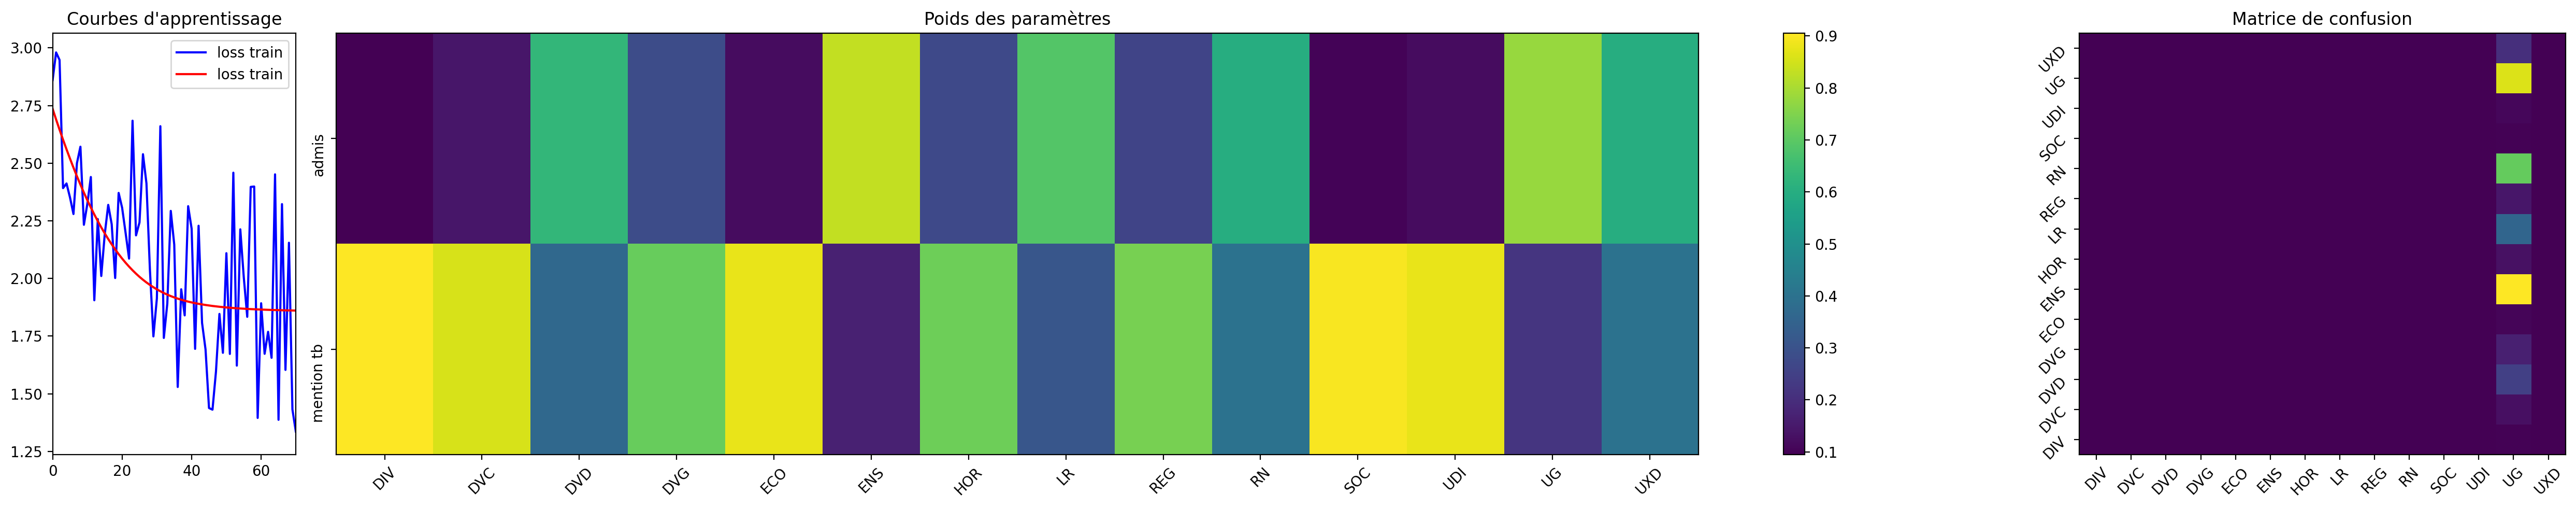

In [342]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(25,5),
    gridspec_kw={"width_ratios":[0.1,0.7,0.2]},
    dpi=200
)

ax[0].plot(
    range(num_epoch),
    losses_train,
    label="loss train",
    color="blue"
)
ax[0].plot(
    range(num_epoch),
    losses_test,
    label="loss train",
    color="red"
)
ax[0].legend()

g = ax[1].imshow(
    Weights.T,
    aspect="auto", 
    cmap="viridis"
)
# fig.colorbar(
#     g,
#     ax=ax[1]
# )

ax[1].set_yticks(
    range(Weights.shape[-1]),
    ["admis","mention tb"],
    rotation=90
)

ax[1].set_xticks(
    range(Weights.shape[0]),
    Encoder_departements.classes_,
    rotation=45
)

ax[2].imshow(
    confusion_matrix(y_test, np.argmax(y_pred, axis=1)),
    origin="lower",
    aspect="auto"
)
ax[2].set_xticks(
    range(Encoder_departements.classes_.shape[0]),
    Encoder_departements.classes_,
    rotation=45
)
ax[2].set_yticks(
    range(Encoder_departements.classes_.shape[0]),
    Encoder_departements.classes_,
    rotation=45
)

ax[0].set_title("Courbes d'apprentissage")
ax[1].set_title("Poids des paramètres")
ax[2].set_title("Matrice de confusion")
plt.tight_layout()
plt.show()

## Nombre de boursier